In [41]:
import importlib
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import utils
importlib.reload(utils)

AUGMENTED_DATA_PATH = "../TUBITAK/datasets/CSV_Multi_Label_Classification_Augmented"
tf.test.is_built_with_cuda()


True

In [30]:
print("TensorFlow version:", tf.__version__)
print("GPU Build Info:", tf.sysconfig.get_build_info())
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Bellek optimizasyonu (GPU kullanımı için)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)#TensorFlow’un başlangıçta minimum bellek tahsis etmesini ve yalnızca gerektiğinde bellek kullanmasını sağlar.
    except RuntimeError as e:
        print(e)


TensorFlow version: 2.10.1
GPU Build Info: OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Physical devices cannot be modified after being initialized


In [42]:
train_df = utils.load_data("train", AUGMENTED_DATA_PATH)
test_df = utils.load_data("test", AUGMENTED_DATA_PATH)
valid_df = utils.load_data("valid", AUGMENTED_DATA_PATH)

augmented_train_dataset = utils.create_dataset(train_df)
augmented_valid_dataset = utils.create_dataset(valid_df)
augmented_test_dataset = utils.create_dataset(test_df)

In [32]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",#ön eğitilmiş ağırlıklar.
    input_shape=(224, 224, 3),
)
base_model.trainable = False# Bu, önceden eğitilmiş ağırlıkların eğitim sırasında değişmesini engeller

80134624/80134624 [==============================] - 23s 0us/step


In [33]:
#Temel model üstğne özel katmanlar ekleniyor.
x = base_model.output
x = GlobalAveragePooling2D()(x)# Flatten yerine genelde daha stabil
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(3, activation='softmax')(x)# Çıkış katmanı (softmax çoklu sınıf sınıflandırması için)
model = Model(inputs=base_model.input, outputs=predictions)#Model ile var olan bir modeli(base_model) yeni modele çevirir(model)

In [34]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', # Çoklu sınıf sınıflandırması için
              metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [35]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',#Doğrulama kaybını izle
        patience=8,#x epoch boyunca iyileşme olmazsa dur
        restore_best_weights=True# En iyi ağırlıklara geri dön
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',# Doğrulama kaybı durursa
        factor=0.5,# Öğrenme oranını %x azalt
        patience=3,# x epoch boyunca iyileşme olmazsa lr düşür
        min_lr=1e-6 # En düşük learningrate oranı
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_VGG19_model.h5",
        monitor='val_loss',
        save_best_only=True,#en düşük val_loss olduğunda kaydet.
        mode='min',
    )
]

In [36]:
history = model.fit(
    augmented_train_dataset,
    validation_data=augmented_valid_dataset,
    batch_size=64,
    epochs=30,
    callbacks=my_callbacks,
    verbose=1,
)

Epoch 1/30
530/530 [==============================] - 190s 356ms/step - loss: 1.0068 - accuracy: 0.5649 - val_loss: 0.6967 - val_accuracy: 0.7004 - lr: 1.0000e-04
Epoch 2/30
530/530 [==============================] - 190s 358ms/step - loss: 0.8295 - accuracy: 0.6508 - val_loss: 0.6276 - val_accuracy: 0.7541 - lr: 1.0000e-04
Epoch 3/30
530/530 [==============================] - 189s 357ms/step - loss: 0.7390 - accuracy: 0.6916 - val_loss: 0.5816 - val_accuracy: 0.7890 - lr: 1.0000e-04
Epoch 4/30
530/530 [==============================] - 188s 356ms/step - loss: 0.6842 - accuracy: 0.7155 - val_loss: 0.5871 - val_accuracy: 0.7853 - lr: 1.0000e-04
Epoch 5/30
530/530 [==============================] - 189s 356ms/step - loss: 0.6417 - accuracy: 0.7330 - val_loss: 0.5767 - val_accuracy: 0.8040 - lr: 1.0000e-04
Epoch 6/30
530/530 [==============================] - 215s 406ms/step - loss: 0.6050 - accuracy: 0.7524 - val_loss: 0.5751 - val_accuracy: 0.8040 - lr: 1.0000e-04
Epoch 7/30
530/530 [==

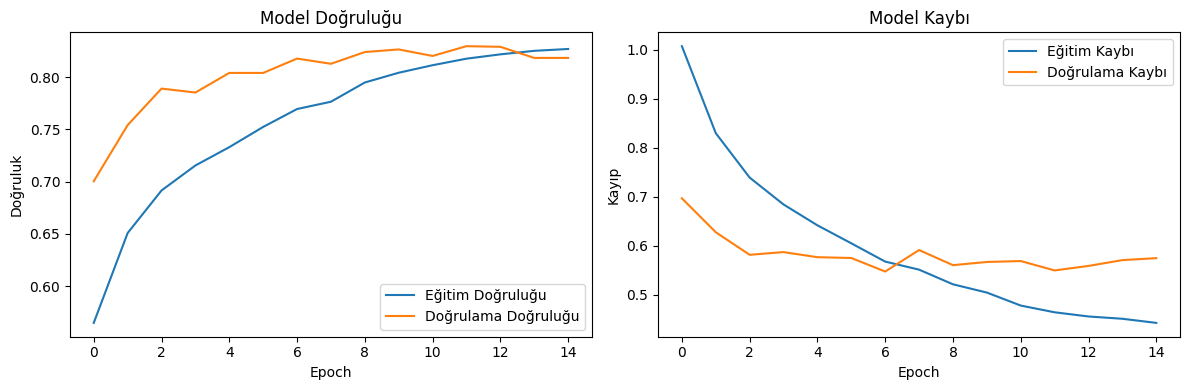

In [39]:
# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))#12X4 LÜK GRAFİK PENCERESİ OLUŞTUR.

#Accuracy Greafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

#Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.7904
F1 Score: 0.8081
ROC-AUC Score: 0.9072


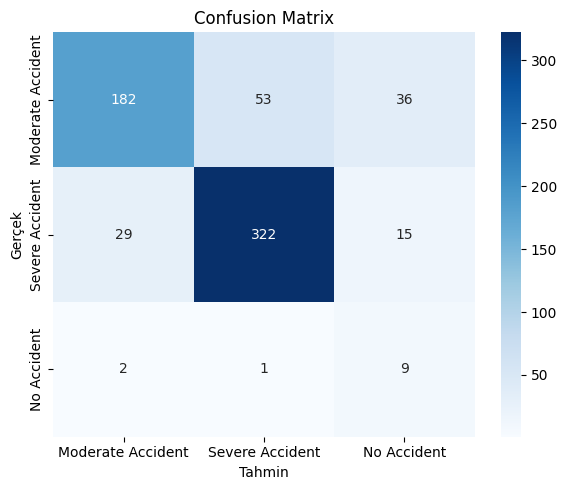


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.85      0.67      0.75       271
  Severe Accident       0.86      0.88      0.87       366
      No Accident       0.15      0.75      0.25        12

         accuracy                           0.79       649
        macro avg       0.62      0.77      0.62       649
     weighted avg       0.84      0.79      0.81       649



In [40]:
class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']
utils.evaluate_model(model, augmented_test_dataset, class_names)